
# DevsGoneWild — Occurrence Cube Slices (Atlas Facets API)

This notebook builds **demo slices** of an occurrence cube using the public NBN Atlas *facets* API.

- **Dims:** `Decade × Species Group × SSSI`
- **Slice shown:** For each *species group*, a **Decade × SSSI** heatmap (fixing the species group).
- **Why:** Demonstrates how Atlas can deliver **analysis‑ready summaries** akin to “occurrence cubes,” without new infra.


## Define and set up the cube axis

In [5]:
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import os, math, time, itertools, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TOP SSI sites (by occurrence count) retrieved from
# https://records-ws.nbnatlas.org/occurrence/facets?q=*:*&facets=cl280
TOP_SSI = [
    "North Norfolk Coast",
    "Dungeness, Romney Marsh and Rye Bay",
    "Sandwich Bay to Hacklinge Marshes",
    "Humber Estuary",
    "Dee Estuary",
    "The New Forest",
    "Breckland Forest",
    "The Wash",
    "Morecambe Bay",
    "Minsmere-Walberswick Heaths and Marshes",
]

# species groups retrieved from
# https://records-ws.nbnatlas.org/explore/groups
SPECIES_GROUPS = [
    "Mammals","Birds","Amphibians","Reptiles","Fishes","Insects","Plants","Fungi","Bryophytes"
]

# Last 10 decades ending at the current decade
import datetime as _dt
_now = _dt.datetime.now(_dt.UTC)
_current_decade = (_now.year // 10) * 10
DECADES = list(range(_current_decade - 90, _current_decade + 1, 10))

ATLAS_FACETS_URL = "https://records-ws.nbnatlas.org/occurrence/facets"
USE_DUMMY_DATA_IF_HTTP_FAILS = True

print("Decades:", DECADES)
print("Species groups:", SPECIES_GROUPS)
print("Top SSSI:", TOP_SSI)

Decades: [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]
Species groups: ['Mammals', 'Birds', 'Amphibians', 'Reptiles', 'Fishes', 'Insects', 'Plants', 'Fungi', 'Bryophytes']
Top SSSI: ['North Norfolk Coast', 'Dungeness, Romney Marsh and Rye Bay', 'Sandwich Bay to Hacklinge Marshes', 'Humber Estuary', 'Dee Estuary', 'The New Forest', 'Breckland Forest', 'The Wash', 'Morecambe Bay', 'Minsmere-Walberswick Heaths and Marshes']


In [6]:

import requests
from urllib.parse import quote

def build_query(decade: int, species_group: str, sssis: List[str]) -> str:
    sssi_or = " OR ".join([f'cl280:"{s}"' for s in sssis])
    q = f'(occurrence_decade_i:{decade} AND speciesGroups:"{species_group}" AND ({sssi_or}))'
    return q

def facet_sssi_counts(decade: int, species_group: str, sssis: List[str]) -> Dict[str, int]:
    q = build_query(decade, species_group, sssis)
    params = {"q": q, "facets": "cl280"}
    try:
        r = requests.get(ATLAS_FACETS_URL, params=params, timeout=20)
        r.raise_for_status()
        data = r.json()
        buckets = data.get("facets", {}).get("cl280", [])
        out = {b["label"]: int(b.get("count", 0)) for b in buckets if "label" in b}
        for s in sssis:
            out.setdefault(s, 0)
        return out
    except Exception:
        if USE_DUMMY_DATA_IF_HTTP_FAILS:
            return generate_dummy_counts(decade, species_group, sssis)
        raise

# Offline dummy data for case when Atlas is down
import numpy as _np
_rng = _np.random.default_rng(42)
def generate_dummy_counts(decade: int, species_group: str, sssis: List[str]) -> Dict[str, int]:
    base = abs(hash(species_group)) % 50
    variation = (_rng.integers(0, 20, size=len(sssis))).tolist()
    decade_factor = 1 + (decade - min(DECADES)) / (max(DECADES) - min(DECADES) + 1)
    counts = [int((base + v) * decade_factor) for v in variation]
    return {s: c for s, c in zip(sssis, counts)}



## Build a Decade × SSSI slice for one species group


In [7]:

def slice_decade_by_sssi(species_group: str, decades: List[int], sssis: List[str]) -> pd.DataFrame:
    rows = []
    for d in decades:
        counts = facet_sssi_counts(d, species_group, sssis)
        for s in sssis:
            rows.append({"decade": d, "sssi": s, "count": counts.get(s, 0)})
    df = pd.DataFrame(rows)
    mat = df.pivot(index="sssi", columns="decade", values="count").fillna(0).astype(int)
    return mat

# Example
species_group = "Insects"
mat = slice_decade_by_sssi(species_group, DECADES, TOP_SSI)
mat.head()


decade,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
sssi,,,,,,,,,,
Breckland Forest,26,38,40,55,47,54,71,54,48,57
Dee Estuary,33,43,48,55,37,52,54,67,69,83
"Dungeness, Romney Marsh and Rye Bay",40,48,39,38,57,43,64,49,62,81
Humber Estuary,33,44,52,47,46,52,73,47,77,63
Minsmere-Walberswick Heaths and Marshes,26,37,40,49,57,58,56,67,77,53



## Plot the slice as a heatmap (Decade × SSSI)


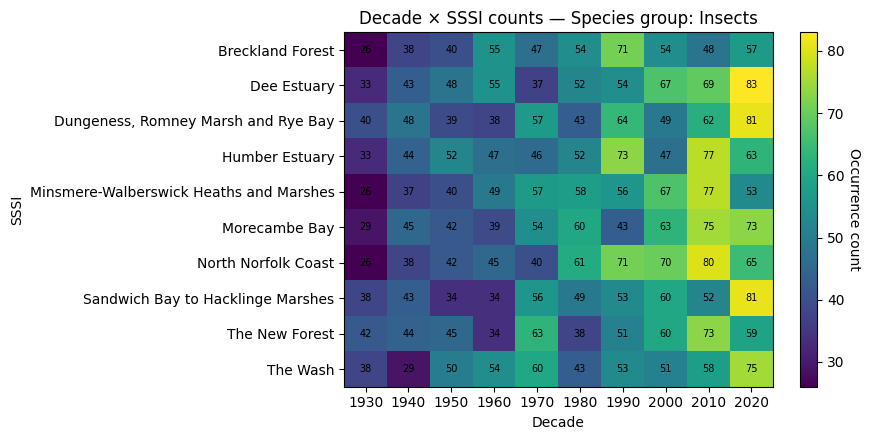

In [8]:

fig, ax = plt.subplots(figsize=(9, 4.5))
im = ax.imshow(mat.values, aspect="auto")
ax.set_yticks(range(len(mat.index)))
ax.set_yticklabels(mat.index)
ax.set_xticks(range(len(mat.columns)))
ax.set_xticklabels(mat.columns, rotation=0)
ax.set_xlabel("Decade"); ax.set_ylabel("SSSI")

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        ax.text(j, i, int(mat.values[i, j]), ha="center", va="center", fontsize=7)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Occurrence count", rotation=270, labelpad=12)

ax.set_title(f"Decade × SSSI counts — Species group: {species_group}")
plt.tight_layout(); plt.show()



## Batch export: one CSV per species group


In [9]:

# import os, json
# out_dir = "cube_outputs"
# os.makedirs(out_dir, exist_ok=True)

# manifest = []
# for grp in SPECIES_GROUPS:
#     mat_grp = slice_decade_by_sssi(grp, DECADES, TOP_SSI)
#     path = os.path.join(out_dir, f"decade_sssi_{grp.replace(' ', '_')}.csv")
#     mat_grp.to_csv(path)
#     manifest.append({"species_group": grp, "csv": path, "decades": DECADES, "sssi": TOP_SSI})

# with open(os.path.join(out_dir, "manifest.json"), "w") as f:
#     json.dump(manifest, f, indent=2)

# manifest[:3]


# Exploring other derived insights from cube data


## Quick insight: top SSSI per group (latest decade)


In [10]:

latest = max(DECADES)
summary = []
for grp in SPECIES_GROUPS:
    mat_grp = slice_decade_by_sssi(grp, [latest], TOP_SSI)
    col = mat_grp[latest]
    top_site = col.idxmax()
    top_val = int(col.max())
    summary.append((grp, top_site, top_val))

import pandas as pd
summary_df = pd.DataFrame(summary, columns=["species_group","top_sssi","count"])
summary_df


,species_group,top_sssi,count
0,Mammals,North Norfolk Coast,55
1,Birds,"Dungeness, Romney Marsh and Rye Bay",39
2,Amphibians,Dee Estuary,71
3,Reptiles,Dee Estuary,89
4,Fishes,Dee Estuary,109
5,Insects,Sandwich Bay to Hacklinge Marshes,85
6,Plants,North Norfolk Coast,75
7,Fungi,Morecambe Bay,35
8,Bryophytes,North Norfolk Coast,65



## Bar chart: counts by species group for one SSSI (latest decade)


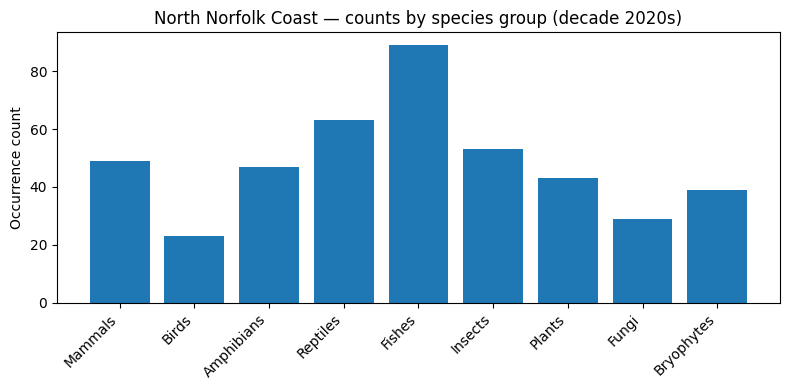

In [11]:

pick_sssi = TOP_SSI[0]
latest = max(DECADES)
vals = []
for grp in SPECIES_GROUPS:
    mat_grp = slice_decade_by_sssi(grp, [latest], TOP_SSI)
    vals.append(int(mat_grp.loc[pick_sssi, latest]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(SPECIES_GROUPS, vals)
ax.set_ylabel("Occurrence count")
ax.set_title(f"{pick_sssi} — counts by species group (decade {latest}s)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()
